https://towardsdatascience.com/15-data-exploration-techniques-to-go-from-data-to-insights-93f66e6805df

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns


In [4]:
from scipy.stats import chi2_contingency # Cramer's V
from sklearn.ensemble import IsolationForest # Outliers


In [5]:
df = pd.read_csv('cars_data.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 13 non-null     int64  
 1   symboling          13 non-null     int64  
 2   normalized-losses  13 non-null     float64
 3   make               13 non-null     object 
 4   fuel-type          13 non-null     object 
 5   aspiration         13 non-null     object 
 6   num-of-doors       13 non-null     int64  
 7   body-style         13 non-null     object 
 8   drive-wheels       13 non-null     object 
 9   engine-location    13 non-null     object 
 10  wheel-base         13 non-null     float64
 11  length             13 non-null     float64
 12  width              13 non-null     float64
 13  height             13 non-null     float64
 14  curb-weight        13 non-null     int64  
 15  engine-type        13 non-null     object 
 16  num-of-cylinders   13 non-nu

# 1. Unique value count of categories

In [7]:
# python ist comprehension init to get categories.
category_cols = [x for x in df.columns if df.dtypes[x] == np.dtype('O') ]
category_cols

['make',
 'fuel-type',
 'aspiration',
 'body-style',
 'drive-wheels',
 'engine-location',
 'engine-type',
 'fuel-system']

<AxesSubplot:>

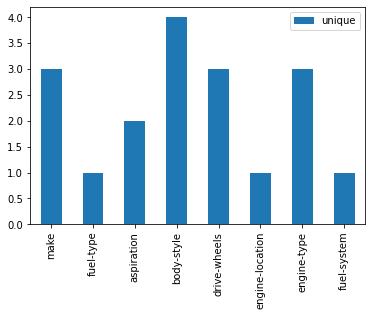

In [8]:
category_data = {x: len(df[x].unique()) for x in category_cols}
category_df = pd.DataFrame.from_dict(
    category_data, orient='index', columns=['unique'])
category_df.plot(kind="bar")

# 2. Frequency Count

<AxesSubplot:>

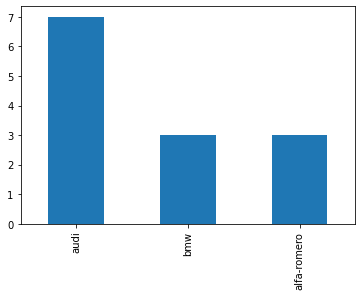

In [9]:
df['make'].value_counts().plot(kind="bar")

# 3. Variance

In [10]:
exclude_list = ['id', 'symboling']
number_types = [np.dtype('int64'), np.dtype('float64')]
number_cols = [x for x in df.columns if df.dtypes[x] in number_types and x not in exclude_list]
number_cols

['normalized-losses',
 'num-of-doors',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'num-of-cylinders',
 'engine-size',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg',
 'price']

In [11]:
num_stats = df[number_cols].describe().transpose()
num_stats['coeff_var'] = num_stats['std'] / num_stats['mean']
num_stats.sort_values('coeff_var', ascending=False, inplace=True)
num_stats

,count,mean,std,min,25%,50%,75%,max,coeff_var
normalized-losses,13.0,93.538462,90.852092,0.00,0.00,158.00,164.00,192.00,0.971281
num-of-doors,13.0,2.923077,1.037749,2.00,2.00,2.00,4.00,4.00,0.355019
price,13.0,15998.076923,5544.141254,0.00,15250.00,16500.00,17710.00,23875.00,0.346550
horsepower,13.0,118.923077,19.737703,101.00,110.00,111.00,121.00,160.00,0.165970
num-of-cylinders,13.0,4.769231,0.725011,4.00,4.00,5.00,5.00,6.00,0.152018
engine-size,13.0,131.307692,16.260302,108.00,130.00,131.00,136.00,164.00,0.123834
city-mpg,13.0,20.000000,2.415229,16.00,19.00,19.00,21.00,24.00,0.120761
highway-mpg,13.0,25.769231,3.031882,20.00,25.00,26.00,28.00,30.00,0.117655
stroke,13.0,3.186154,0.317714,2.68,2.80,3.40,3.40,3.47,0.099717
curb-weight,13.0,2694.153846,256.627761,2337.00,2507.00,2710.00,2844.00,3086.00,0.095254


<AxesSubplot:>

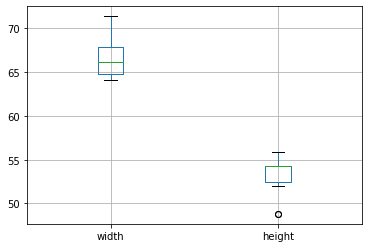

In [12]:
df.boxplot(column=['width', 'height'])

# 4. Pareto Analysis

<AxesSubplot:xlabel='price'>

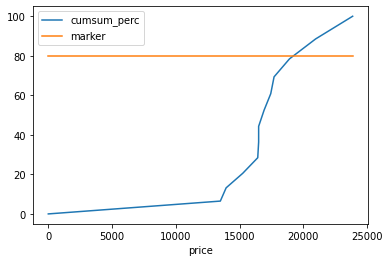

In [13]:
price_df = df.copy()
total_sales = price_df['price'].sum()

price_df.sort_values('price', inplace=True)
price_df['cumsum'] = price_df['price'].cumsum()
price_df['cumsum_perc'] = 100*price_df['cumsum']/total_sales
price_df['marker'] = 80
price_df.plot.line(x='price', y=['cumsum_perc', 'marker'])

In [14]:
price_df['price'].describe()

count       13.000000
mean     15998.076923
std       5544.141254
min          0.000000
25%      15250.000000
50%      16500.000000
75%      17710.000000
max      23875.000000
Name: price, dtype: float64

# 5. Histogram

<AxesSubplot:ylabel='Frequency'>

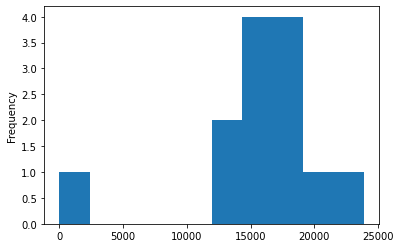

In [15]:
price_df['price'].plot.hist()

# 6. Correlation between numerical fields

In [16]:
corr = df[number_cols].corr()
corr

,normalized-losses,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
normalized-losses,1.000000,0.485724,0.516561,0.257339,0.026301,0.623251,-0.227274,-0.100433,-0.282058,0.285797,-0.028417,0.218247,-0.371329,0.176731,0.393446,0.212564,0.432285
num-of-doors,0.485724,1.000000,0.615766,0.655114,0.602183,0.679354,0.172150,-0.136320,-0.314546,-0.042679,0.345294,0.052018,-0.289173,0.491834,0.000000,-0.191513,0.371997
wheel-base,0.516561,0.615766,1.000000,0.876084,0.742373,0.961902,0.365913,0.287643,-0.042417,-0.167561,0.573033,-0.253660,-0.034859,0.412642,-0.213606,-0.278769,0.284434
length,0.257339,0.655114,0.876084,1.000000,0.950022,0.796429,0.567810,0.230199,0.033151,-0.180230,0.527191,-0.290085,0.019395,0.358100,-0.392559,-0.463660,0.336114
width,0.026301,0.602183,0.742373,0.950022,1.000000,0.648964,0.711732,0.282250,0.107451,-0.362213,0.635181,-0.386350,0.212979,0.336811,-0.575420,-0.617133,0.177854
height,0.623251,0.679354,0.961902,0.796429,0.648964,1.000000,0.271255,0.309707,-0.037535,-0.230820,0.582832,-0.080653,-0.097977,0.375313,-0.092517,-0.184475,0.427581
curb-weight,-0.227274,0.172150,0.365913,0.567810,0.711732,0.271255,1.000000,0.623668,0.537231,-0.548035,0.587828,-0.693352,0.726193,-0.090470,-0.903764,-0.858169,-0.032161
num-of-cylinders,-0.100433,-0.136320,0.287643,0.230199,0.282250,0.309707,0.623668,1.000000,0.883056,-0.729885,0.672343,-0.277288,0.615938,-0.502850,-0.571080,-0.405353,0.169260
engine-size,-0.282058,-0.314546,-0.042417,0.033151,0.107451,-0.037535,0.537231,0.883056,1.000000,-0.500699,0.394160,-0.177728,0.484073,-0.775905,-0.511386,-0.331440,0.200692
bore,0.285797,-0.042679,-0.167561,-0.180230,-0.362213,-0.230820,-0.548035,-0.729885,-0.500699,1.000000,-0.815287,0.149322,-0.699313,0.107918,0.537150,0.421070,0.046452


In [17]:
corr.style.background_gradient()

,normalized-losses,num-of-doors,wheel-base,length,width,height,curb-weight,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
normalized-losses,1.000000,0.485724,0.516561,0.257339,0.026301,0.623251,-0.227274,-0.100433,-0.282058,0.285797,-0.028417,0.218247,-0.371329,0.176731,0.393446,0.212564,0.432285
num-of-doors,0.485724,1.000000,0.615766,0.655114,0.602183,0.679354,0.172150,-0.136320,-0.314546,-0.042679,0.345294,0.052018,-0.289173,0.491834,0.000000,-0.191513,0.371997
wheel-base,0.516561,0.615766,1.000000,0.876084,0.742373,0.961902,0.365913,0.287643,-0.042417,-0.167561,0.573033,-0.253660,-0.034859,0.412642,-0.213606,-0.278769,0.284434
length,0.257339,0.655114,0.876084,1.000000,0.950022,0.796429,0.567810,0.230199,0.033151,-0.180230,0.527191,-0.290085,0.019395,0.358100,-0.392559,-0.463660,0.336114
width,0.026301,0.602183,0.742373,0.950022,1.000000,0.648964,0.711732,0.282250,0.107451,-0.362213,0.635181,-0.386350,0.212979,0.336811,-0.575420,-0.617133,0.177854
height,0.623251,0.679354,0.961902,0.796429,0.648964,1.000000,0.271255,0.309707,-0.037535,-0.230820,0.582832,-0.080653,-0.097977,0.375313,-0.092517,-0.184475,0.427581
curb-weight,-0.227274,0.172150,0.365913,0.567810,0.711732,0.271255,1.000000,0.623668,0.537231,-0.548035,0.587828,-0.693352,0.726193,-0.090470,-0.903764,-0.858169,-0.032161
num-of-cylinders,-0.100433,-0.136320,0.287643,0.230199,0.282250,0.309707,0.623668,1.000000,0.883056,-0.729885,0.672343,-0.277288,0.615938,-0.502850,-0.571080,-0.405353,0.169260
engine-size,-0.282058,-0.314546,-0.042417,0.033151,0.107451,-0.037535,0.537231,0.883056,1.000000,-0.500699,0.394160,-0.177728,0.484073,-0.775905,-0.511386,-0.331440,0.200692
bore,0.285797,-0.042679,-0.167561,-0.180230,-0.362213,-0.230820,-0.548035,-0.729885,-0.500699,1.000000,-0.815287,0.149322,-0.699313,0.107918,0.537150,0.421070,0.046452


# 7. Pearson correlation and trend

In [18]:
x = 'city-mpg'
y = 'highway-mpg'

In [19]:
df[[x, y]].corr(method='pearson')

,city-mpg,highway-mpg
city-mpg,1.000000,0.944553
highway-mpg,0.944553,1.000000


In [20]:
# numpy
m, b = np.polyfit(df[x], df[y], 1)
m,b

(1.1857142857142857, 2.0549450549450596)

In [21]:
# scipy
from scipy.stats import linregress
linregress(df[x], df[y])

LinregressResult(slope=1.1857142857142857, intercept=2.0549450549450547, rvalue=0.9445526544746536, pvalue=1.1804625645004964e-06, stderr=0.12428186749819843)

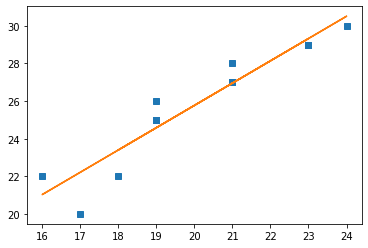

In [22]:
# Matplotlib only method
fig, ax = plt.subplots()
ax.plot(df[x], df[y], linewidth=0, marker='s', label='Data Points')
ax.plot(df[x], b + m*df[x], label="line")
plt.show()

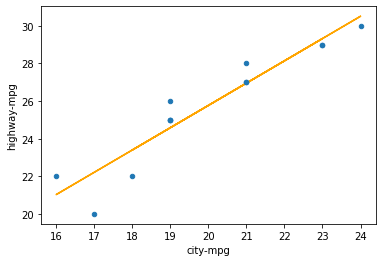

In [23]:
# DataFrame.plot with additional stuff method
fig, ax = plt.subplots()
df.plot(kind="scatter", x=x, y=y, ax=ax)
ax.plot(df[x], b + m*df[x], label="line", zorder=-1, color="orange")
plt.show()

# Pause - need to encode category data

In [24]:
train_df = df.copy()
for x in category_cols:
    label_encoder = LabelEncoder()
    label_encoder.fit(train_df[x])
    train_df[x] = label_encoder.transform(train_df[x])

In [25]:
train_df

,id,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,0,3,0.0,0,0,0,2,0,2,0,...,130,0,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,1,3,0.0,0,0,0,2,0,2,0,...,130,0,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,2,1,0.0,0,0,0,2,1,2,0,...,152,0,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,3,2,164.0,1,0,0,4,2,1,0,...,109,0,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,4,2,164.0,1,0,0,4,2,0,0,...,136,0,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
5,5,2,0.0,1,0,0,2,2,1,0,...,136,0,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0
6,6,1,158.0,1,0,0,4,2,1,0,...,136,0,3.19,3.40,8.5,110.0,5500.0,19,25,17710.0
7,7,1,0.0,1,0,0,4,3,1,0,...,136,0,3.19,3.40,8.5,110.0,5500.0,19,25,18920.0
8,8,1,158.0,1,0,1,4,2,1,0,...,131,0,3.13,3.40,8.3,140.0,5500.0,17,20,23875.0
9,9,0,0.0,1,0,1,2,1,0,0,...,131,0,3.13,3.40,7.0,160.0,5500.0,16,22,0.0


# 8. Cramer's V

In [26]:
#def cramers_V(var1,var2) :
#    crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
#    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
#    obs = np.sum(crosstab) # Number of observations
#    mini = min(crosstab.shape) # Take the minimum value between the columns and the rows of the cross table
#    return (stat/(obs*mini))

In [27]:
def cramers_V(var1,var2) :
    crosstab = np.array(pd.crosstab(var1,var2))
    chi2 = chi2_contingency(crosstab)[0]
    n = np.sum(crosstab)
    phi2 = chi2/n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))


In [28]:
cat_df = train_df[category_cols]
rows= []
for var1 in cat_df:
    cols = []
    for var2 in cat_df:
        cramers = cramers_V(cat_df[var1], cat_df[var2]) # Cramer's V test
        cols.append(round(cramers, 2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(cols)
    
cramers_results = np.array(rows)
cramer_df = pd.DataFrame(cramers_results, columns=cat_df.columns, index=cat_df.columns)

cramer_df.fillna(0, inplace=True)


/Users/alan/virtualenv_py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


<AxesSubplot:>

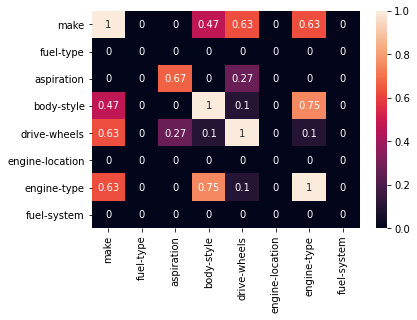

In [29]:
sns.heatmap(cramer_df, annot=True)


# 9. Correlation between two categorical fields


In [30]:
# pass

# 10. Cluster size analysis

In [31]:
small_df = train_df[['width', 'height']].copy()
X = np.array(small_df)

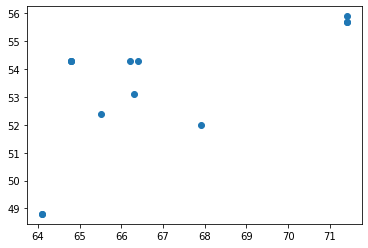

In [32]:
plt.scatter(X[:,0], X[:,1])

In [33]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

In [34]:
# Array of coords for each cluster center
kmeans.cluster_centers_

array([[65.8375    , 53.625     ],
       [71.4       , 55.76666667],
       [64.1       , 48.8       ]])

In [35]:
# For each data point, the array index of cluster they have been assigned to
kmeans.labels_

array([2, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0], dtype=int32)

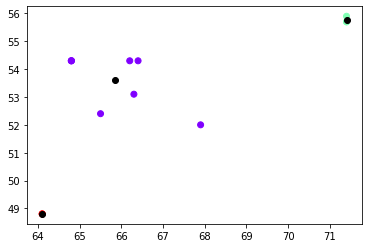

In [36]:
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], color='black')

In [37]:
X = np.array(train_df)
cluster_size_range = range(2, 6)

data = []
for c in cluster_size_range:
    kmeans = KMeans(n_clusters=c)
    kmeans.fit(X)
    counts = pd.DataFrame(kmeans.labels_)[0].value_counts().to_dict()
    counts['size'] = c
    data.append(counts)
    
cluster_analysis_df = pd.DataFrame.from_dict(data)
cluster_analysis_df.fillna(0, inplace=True)
cluster_analysis_df

,0,1,size,2,3,4
0,12,1,2,0.0,0.0,0.0
1,10,2,3,1.0,0.0,0.0
2,2,7,4,1.0,3.0,0.0
3,3,1,5,2.0,6.0,1.0


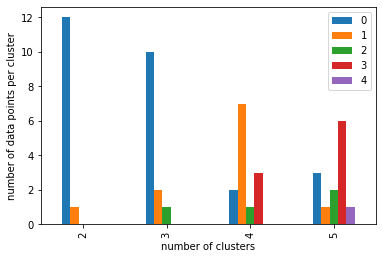

In [38]:
x_dim = "size"
y_dim = cluster_analysis_df.columns.drop("size")
cluster_analysis_df.plot(x=x_dim, y=y_dim, kind="bar")
plt.xlabel('number of clusters')
plt.ylabel('number of data points per cluster')
plt.show()

11. Clustering or segementation

Just going to try to reproduce the graph with those variables they targeted for segments

In [39]:
segment_cols = [
    'curb-weight', 
    'length', 
    'engine-size', 
    'highway-mpg', 
    'fuel-system']
segment_df = train_df[segment_cols]
X = np.array(segment_df)
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.labels_


array([1, 1, 0, 3, 0, 1, 0, 2, 2, 2, 3, 3, 4], dtype=int32)

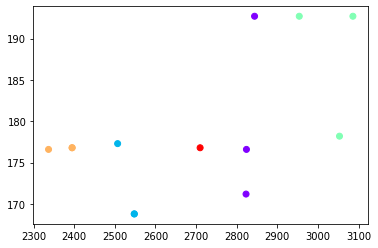

In [40]:
g_x = segment_df['curb-weight']
g_y = segment_df['length']
plt.scatter(g_x, g_y, c=kmeans.labels_, cmap='rainbow')


# 13. Outlier analysis for individual column

In [41]:
# pass

# 14. Outlier analysis for multiple columns

In [42]:
anom_df = train_df.copy()
model = IsolationForest()
model.fit(anom_df)
anom_df['scores'] = model.decision_function(train_df)
anom_df['anomaly'] = model.predict(train_df)
anom_df[['scores', 'anomaly']]

,scores,anomaly
0,-0.043572,-1
1,-0.028094,-1
2,-0.047963,-1
3,0.016757,1
4,0.057878,1
5,0.073355,1
6,0.066351,1
7,0.031411,1
8,-0.022253,-1
9,-0.058293,-1


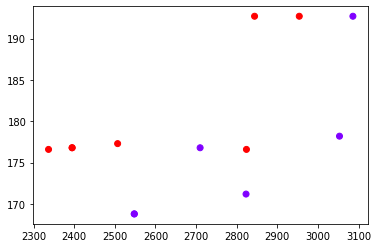

In [43]:
g_x = anom_df['curb-weight']
g_y = anom_df['length']
plt.scatter(g_x, g_y, c=anom_df['anomaly'], cmap='rainbow')


# 15. Other visualisations


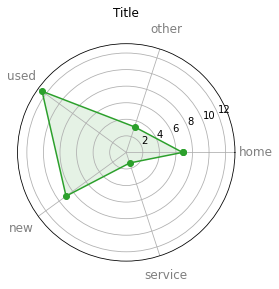

In [44]:

df = pd.DataFrame({'Col A': ['home', 'other', 'used', 'new', 'service'],
                   'Col B': [6.797, 3.243, 12.567, 8.985, 1.345]})
fig = plt.figure()
ax = fig.add_subplot(111, projection="polar")

# theta has 5 different angles, and the first one repeated
theta = np.arange(len(df) + 1) / float(len(df)) * 2 * np.pi
# values has the 5 values from 'Col B', with the first element repeated
values = df['Col B'].values
values = np.append(values, values[0])

# draw the polygon and the mark the points for each angle/value combination
l1, = ax.plot(theta, values, color="C2", marker="o", label="Name of Col B")
plt.xticks(theta[:-1], df['Col A'], color='grey', size=12)
ax.tick_params(pad=10) # to increase the distance of the labels to the plot
# fill the area of the polygon with green and some transparency
ax.fill(theta, values, 'green', alpha=0.1)

# plt.legend() # shows the legend, using the label of the line plot (useful when there is more than 1 polygon)
plt.title("Title")
plt.show()